# Load the data

In [4]:
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()

CKPT_PATH = 'checkpoints/resnet18/'

In [5]:
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from torch import nn
import pandas as pd
import kornia.augmentation as K
import torch
from src.pickle_loader import load_object, save_object

stats = load_object("../data/eurosat_ms_mean_std")
mean = stats['mean']
std = stats['std']
chan_idx = stats['idx']

# CHANNELS = [12, 11, 8, 7]
CHANNELS = [3, 2, 1]
NUM_CLASSES = 10
NUM_AUG = 1

df = pd.read_csv(config.TRAIN_FILE)

encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, "../data/on_hot_encoder")

In [6]:
from sklearn.model_selection import train_test_split
from src.datasets.EuroSatMS import EuroSatMS


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
print(df['label'].unique())
test_df, val_df = train_test_split(val_df, test_size=0.7)

ds_train = EuroSatMS(
    train_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

ds_val = EuroSatMS(
    val_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

ds_test = EuroSatMS(
    test_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

print(f"""\n{c.OKCYAN}Train dataset:   {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKCYAN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKCYAN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']

Preloading images...

Images:         21600
Augmentations:  21600
Jobs:           -4 

Time taken:      0 min 21.83963656425476 sec 

Preloading images...

Images:         3780
Augmentations:  3780
Jobs:           -4 

Time taken:      0 min 2.41202712059021 sec 

Preloading images...

Images:         1620
Augmentations:  1620
Jobs:           -4 

Time taken:      0 min 1.0215508937835693 sec 

Train dataset:   21600 samples
Validation dataset: 3780 samples
Test dataset:       1620 samples


In [7]:
transform_mean_std = transforms.Compose([
    K.Normalize(mean=mean[CHANNELS], std=std[CHANNELS])
])

transform_pt = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

p1 = 0.4
p2 = 0.6
p3 = 0.5
augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=p3),
    K.RandomVerticalFlip(p=p3),
    K.RandomAffine(degrees=45, translate=None, scale=None, shear=None, resample="nearest", padding_mode=2, p=p2),
    K.RandomShear(shear=0.3, resample="nearest", padding_mode=2, p=p2),
    #K.RandomContrast(contrast=(0.5, 1.5), p=p2),
    K.RandomBrightness((0.7, 1.3), p=p2),
    #K.RandomPlasmaContrast(p=p1),
    #K.RandomSolarize(thresholds=0.01, p=p1),
    #K.RandomSharpness(sharpness=0.9, p=p1),
    K.RandomSharpness(sharpness=0.8, p=p1),
    #K.RandomSharpness(sharpness=0.5, p=p1),
    #K.RandomSaturation(p=p1),
    # K.RandomBoxBlur(kernel_size=(3, 3), p=p2),
    #K.RandomEqualize(p=p1),
    K.CenterCrop(size=(64, 64))
)

ds_train.augment = augmentation
ds_val.augment = augmentation
ds_test.augment = None

ds_train.transform = None
ds_val.transform = None
ds_test.transform = None

In [8]:
from src.training.data import EuroSatDataModule

print(ds_val[0][0].shape)

BATCH_SIZE = 32

data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)
print(f"""{c.OKGREEN}Initialized the data module...{c.ENDC}""")

torch.Size([3, 64, 64])
Initialized the data module...


# CNN Model Training

In [ ]:
import numpy as np

KERNEL_SIZE = [5, 3]
LEARNING_RATE = 0.03
MOMENTUM = 0.9
GAMMA = 0.9
DROPOUT = 0.3
EPOCHS = 15
CLASS_WEIGHTS = {'AnnualCrop': 9,
                 'Forest': 9,
                 'HerbaceousVegetation': 8, 
                 'Highway': 9, 
                 'Industrial': 9,
                 'Pasture': 9, 
                 'PermanentCrop': 9, 
                 'Residential': 9, 
                 'River': 9, 
                 'SeaLake': 9}

w = np.array(list(CLASS_WEIGHTS.values()))
w_min, w_max = w.min(), w.max()
w = (w - w_min) / (w_max - w_min)

fname = "cnn_c"
for c in CHANNELS:
    fname += str(c)
fname += "_k"
for k in KERNEL_SIZE:
    fname += str(k)
fname += "_lr" + str(LEARNING_RATE)
fname += "_m" + str(MOMENTUM)
fname += "_g" + str(GAMMA)
fname += "_d" + str(DROPOUT)

print("Model name: ", fname)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from src.training.cnn import LitEuroSatCnn
from datetime import datetime

lightning_model = LitEuroSatCnn(
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE, 
    num_channels=len(CHANNELS), 
    kernel_size=KERNEL_SIZE,
    momentum=MOMENTUM,
    gamma=GAMMA,
    weights=torch.tensor(w, dtype=torch.float32),
    dropout=DROPOUT
)

logger = WandbLogger(
    project="eurosat_cnn",
    name="cnn_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename=fname + '_{ep:02d}-{val_l:.2f}',
    save_top_k=2, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(lightning_model, datamodule=data_module)

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt

trainer.test(lightning_model, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)
metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
all_preds = np.concatenate(lightning_model.ep_out)
all_true = np.concatenate(lightning_model.ep_true)
true_ep = torch.tensor(all_true)
pred_ep = torch.tensor(all_preds)
metric.update(pred_ep, true_ep)
fig, ax = metric.plot()
plt.show()
print(encoder.categories_[0])

# Pretrained Model Training
### Training Phase 1
##### Pretrained ResNet50, ResNet18, AlexNet Model

In [9]:
import torchgeo.models as models
from torchgeo.models import ResNet18_Weights, ResNet50_Weights


def get_pretrained_model(model_name):
    if model_name == "B13_rn50_moco_0099":
        m = models.resnet50(weights=None)
        m.fc = nn.Linear(2048,19)
        m.conv1 = nn.Conv2d(
            13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        ckp = torch.load("B13_rn50_moco_0099.pth", map_location="cpu")
        sd = ckp['state_dict']
        
        for key in list(sd.keys()):
            if key.startswith('module.encoder_q') and not key.startswith('module.encoder_q.fc'):
                sd[key[len("module.encoder_q."):]] = sd[key]
            del sd[key]
        
        msg = m.load_state_dict(sd, strict=False)
        assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
        
        return m
    elif "resnet18_RGB_MOCO" in model_name:
        return models.resnet18(weights=ResNet18_Weights.SENTINEL2_RGB_MOCO)
    elif "resnet50_RGB_MOCO" in model_name:
        return models.resnet50(weights=ResNet50_Weights.SENTINEL2_RGB_MOCO)

m_name = "resnet50_RGB_MOCO"

In [10]:
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from pytorch_lightning import Trainer
from src.training.pretrainedModels import EuroSatPreTrainedModel

model = get_pretrained_model(m_name)

model_train = EuroSatPreTrainedModel(
    backbone=model,
    learning_rate=0.03,
    gamma=0.95,
    momentum=0.8,
    dropout=0.5,
    weight_decay=1e-4
)

logger = WandbLogger(
    project="eurosat_resnet",
    name="resnet_pretrained_v2",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    save_top_k=1, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=10,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: the-virus. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ResNet           | 25.6 M
1 | classifier | Sequential       | 10.0 K
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
10.0 K    Trainable params
25.6 M    Non-trainable params
25.6 M    Total params
102.268   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at /home/tobias/Desktop/Uni/SS24/ML/EuroSat_Dataset_LUC/checkpoints/resnet18/12-20/epoch=9-step=6750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/tobias/Desktop/Uni/SS24/ML/EuroSat_Dataset_LUC/checkpoints/resnet18/12-20/epoch=9-step=6750.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8382716178894043     │
│    test_accuracy_epoch    │            0.0            │
│         test_loss         │    1.3339996337890625     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3339996337890625,
  'test_accuracy_epoch': 0.0,
  'test_accuracy': 0.8382716178894043}]

In [ ]:
model = get_pretrained_model(m_name)

model_train = EuroSatPreTrainedModel.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    backbone=model,
    freeze_backbone=False,
    learning_rate=0.0001,
    gamma=0.7,
    momentum=0.9,
    dropout=0.3,
    weight_decay=1e-4
)

logger = WandbLogger(
    project="eurosat_resnet",
    name="resnet18_p2",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    save_top_k=1, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=3,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

In [ ]:
trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)

# Predict on the test set

In [12]:
from torch import nn
from src.datasets.EuroSatTest import EuroSatTestSet
from torch.utils.data import DataLoader
from config import Config

config = Config()

# CHANNELS = [11, 10, 8, 7, 6, 5, 4, 3, 2, 1, 0]
CHANNELS = [3, 2, 1]

dataset = EuroSatTestSet(config.TEST_MS_DIR, select_chan=CHANNELS, add_b10=False) #, augment=aug)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


Error during unpickling object (Possibly unsupported): [Errno 2] No such file or directory: 'data/on_hot_encoder.pickle'

Preloading images...
Number of images: 4232
Number of jobs:   -4 

Time taken:      0 min 11.507445812225342 sec 


In [13]:
from src.training.pretrainedModels import EuroSatPreTrainedModel
from src.training.cnn import LitEuroSatCnn
from config import Config

config = Config()

# model_eval = LitEuroSatCnn.load_from_checkpoint(
#     "checkpoints/cnn/14-18/cnn_c87654_k53_lr0.03_m0.9_g0.8epoch=09-val_loss=0.68.ckpt", #checkpoint_callback.best_model_path,
#     num_classes=NUM_CLASSES,
#     learning_rate=0.025, 
#     num_channels=len(CHANNELS), 
#     kernel_size=[5, 3],
#     momentum=0.9,
#     gamma=0.9,
#     weights=torch.tensor(w, dtype=torch.float32)
# )


model = get_pretrained_model(m_name)
model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    backbone=model,
    learning_rate=1e-4,
    momentum=0.9,
    dropout=0,
    weight_decay=0.0001
)

# Set the model to evaluation mode
model_eval.eval()

EuroSatPreTrainedModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256,

In [14]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eval = model_eval.to(device)
model_eval.eval()

N_CLASSES = 10
categorys = encoder.categories_[0]
print(categorys)

predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

rounds = 3

    
with torch.no_grad():
    for batch in dataloader:
        inputs, samp_id = batch
        inputs = inputs.to(device)
        # for rounds predict inputs and select the most frequent prediction
        # round_preds = []
        # for r in range(rounds):
        #     inp = augmentation(inputs)
        #     outputs = model_eval(inp)
        #     _, preds = torch.max(outputs, 1)
        #     round_preds.append(preds.cpu().numpy())
        # 
        # round_preds = np.array(round_preds).T
        # preds = []
        # for i in range(round_preds.shape[0]):
        #     t, c = np.unique(round_preds[i], return_counts=True)
        #     preds.append(int(t[np.argmax(c)]))
            
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = np.array(preds.cpu().numpy())
            
        # preds_enc = np.zeros((preds.size, N_CLASSES))
        # preds_enc[np.arange(preds.size), preds] = 1
        
        pred_labels = np.array([categorys[p] for p in preds])
        # true_labels = np.array([categorys[np.argmax(p)] for p in samp_id.cpu().numpy()])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu())
        # probabilities.extend(probs.cpu())
        # true_l.extend(true_labels)
        # ohe.extend(preds_enc)
    


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [15]:
import pandas as pd


sub_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())
print(np.array(sample_ids))

sub_df.to_csv('submission.csv', index=False)
print(np.unique(predictions, return_counts=True))

      test_id                 label
2146        0                Forest
3417        1           Residential
1392        2                Forest
1716        3               SeaLake
1868        4  HerbaceousVegetation
[1385 2727 2849 ... 1628 3387 1208]
(array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype='<U20'), array([636, 424, 397, 473, 215, 173, 311, 550, 206, 847]))


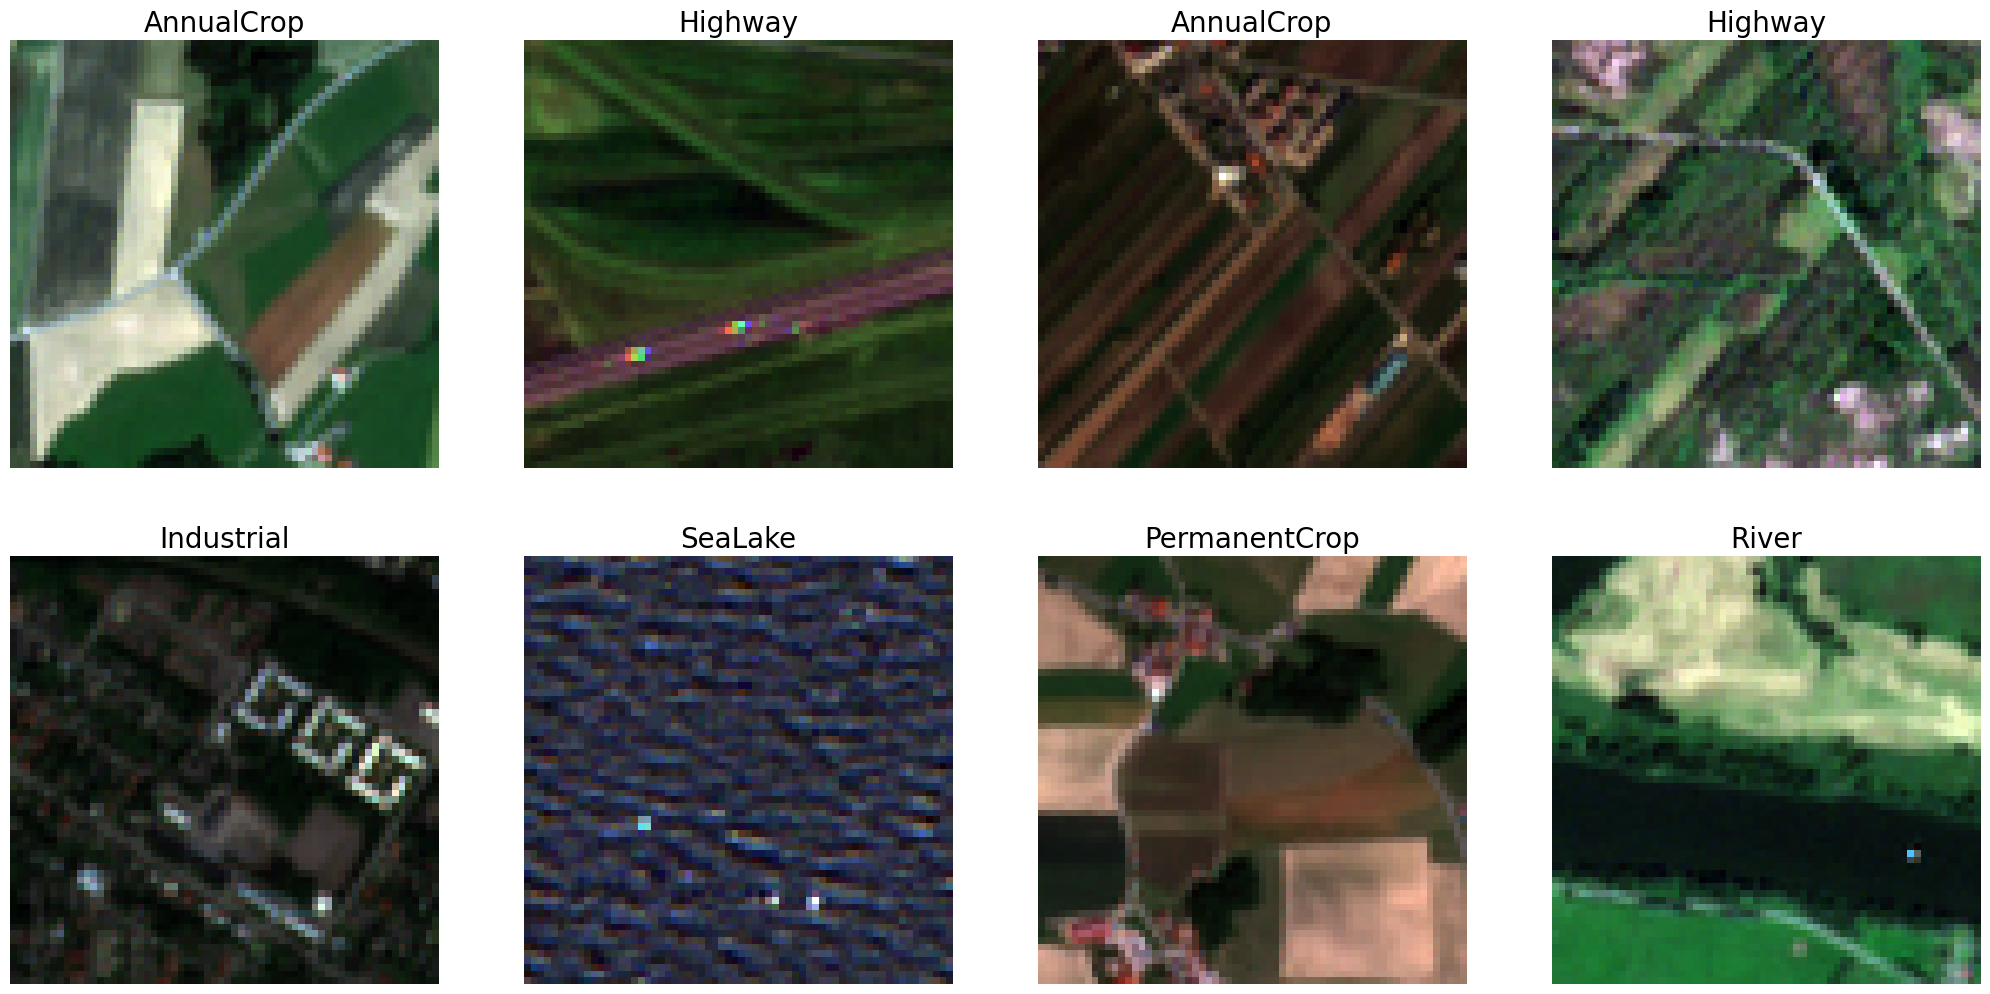

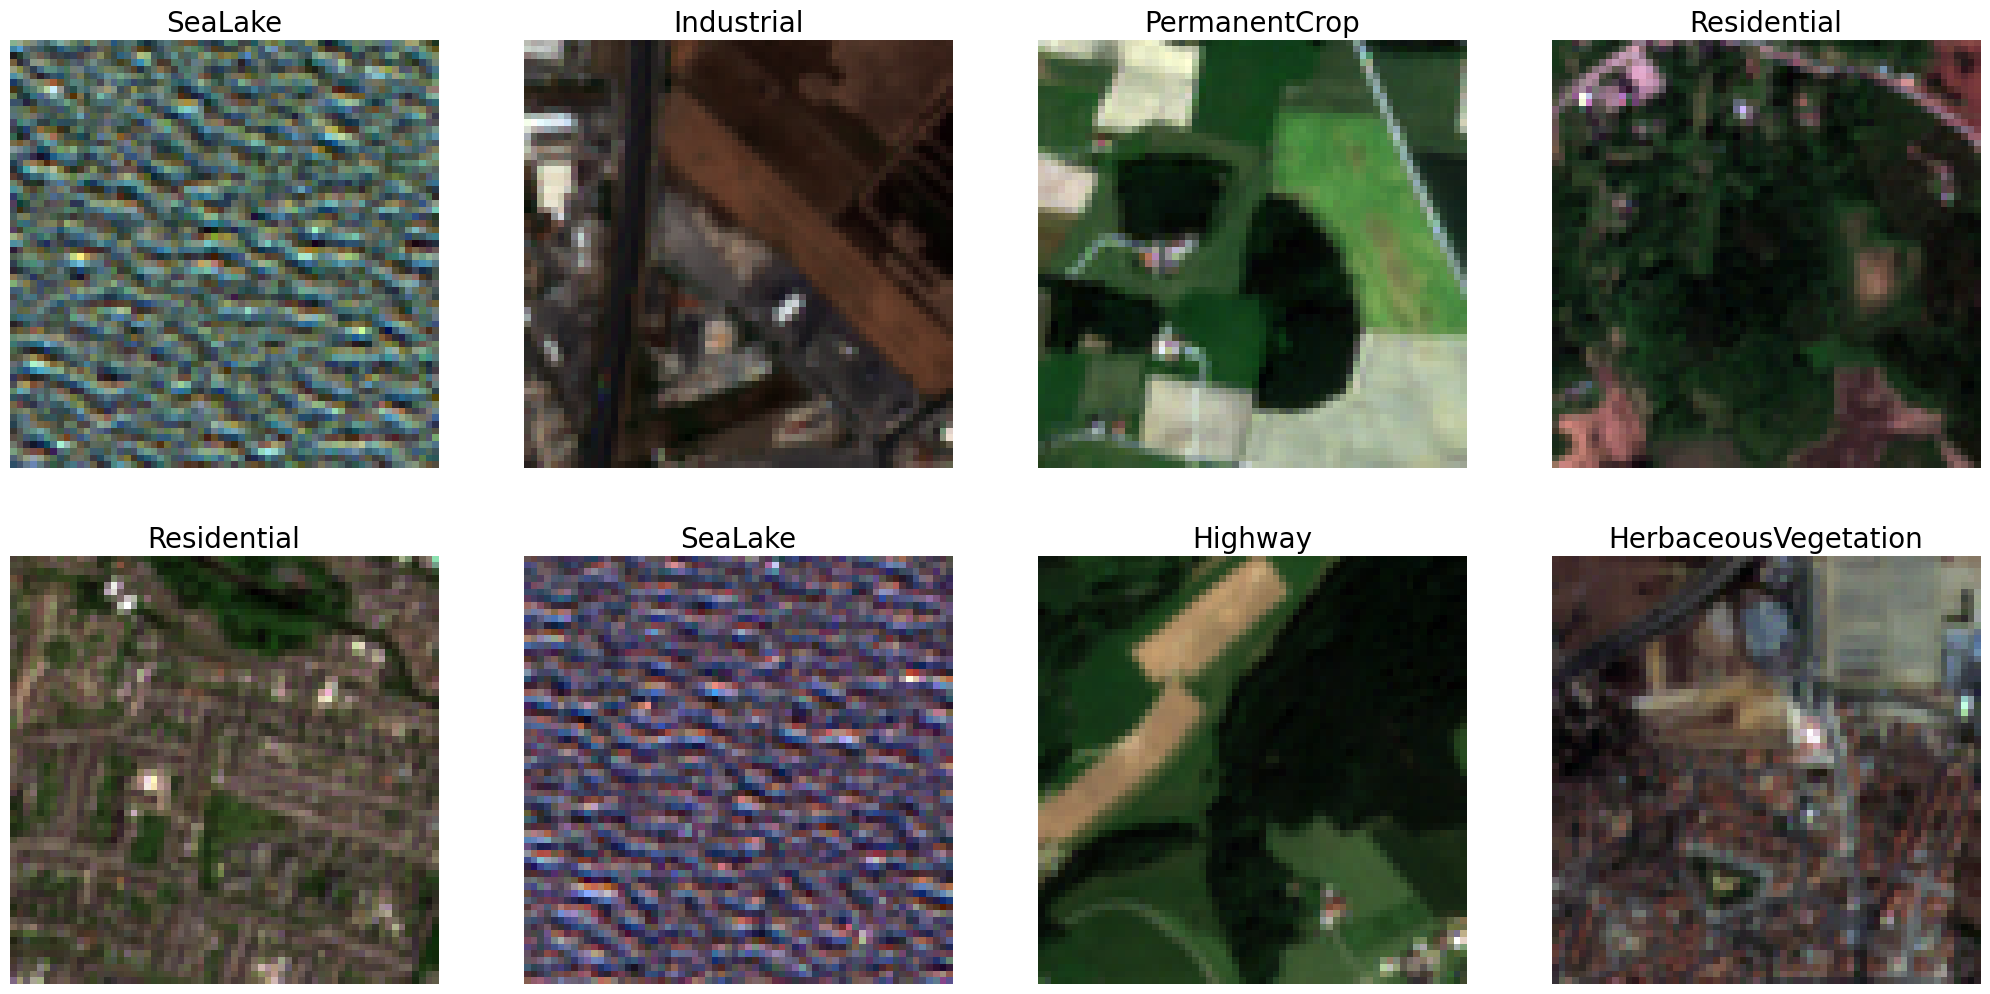

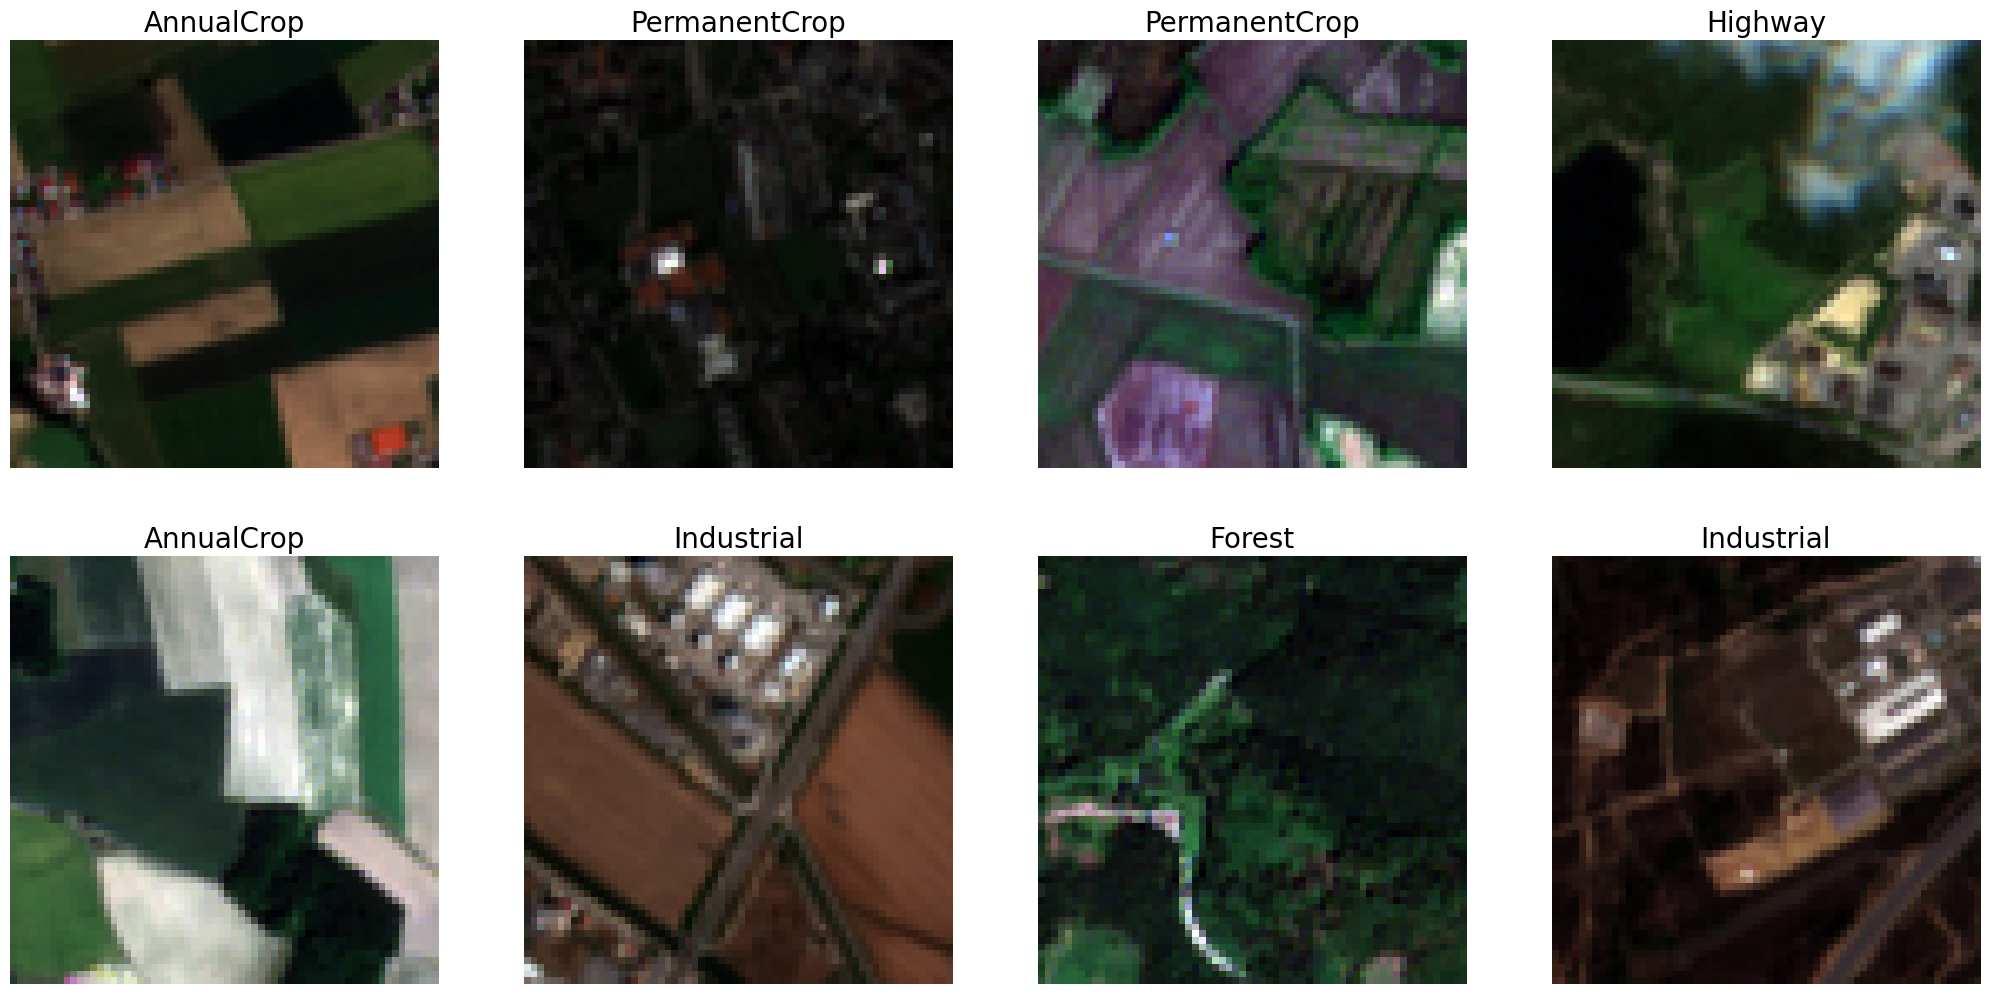

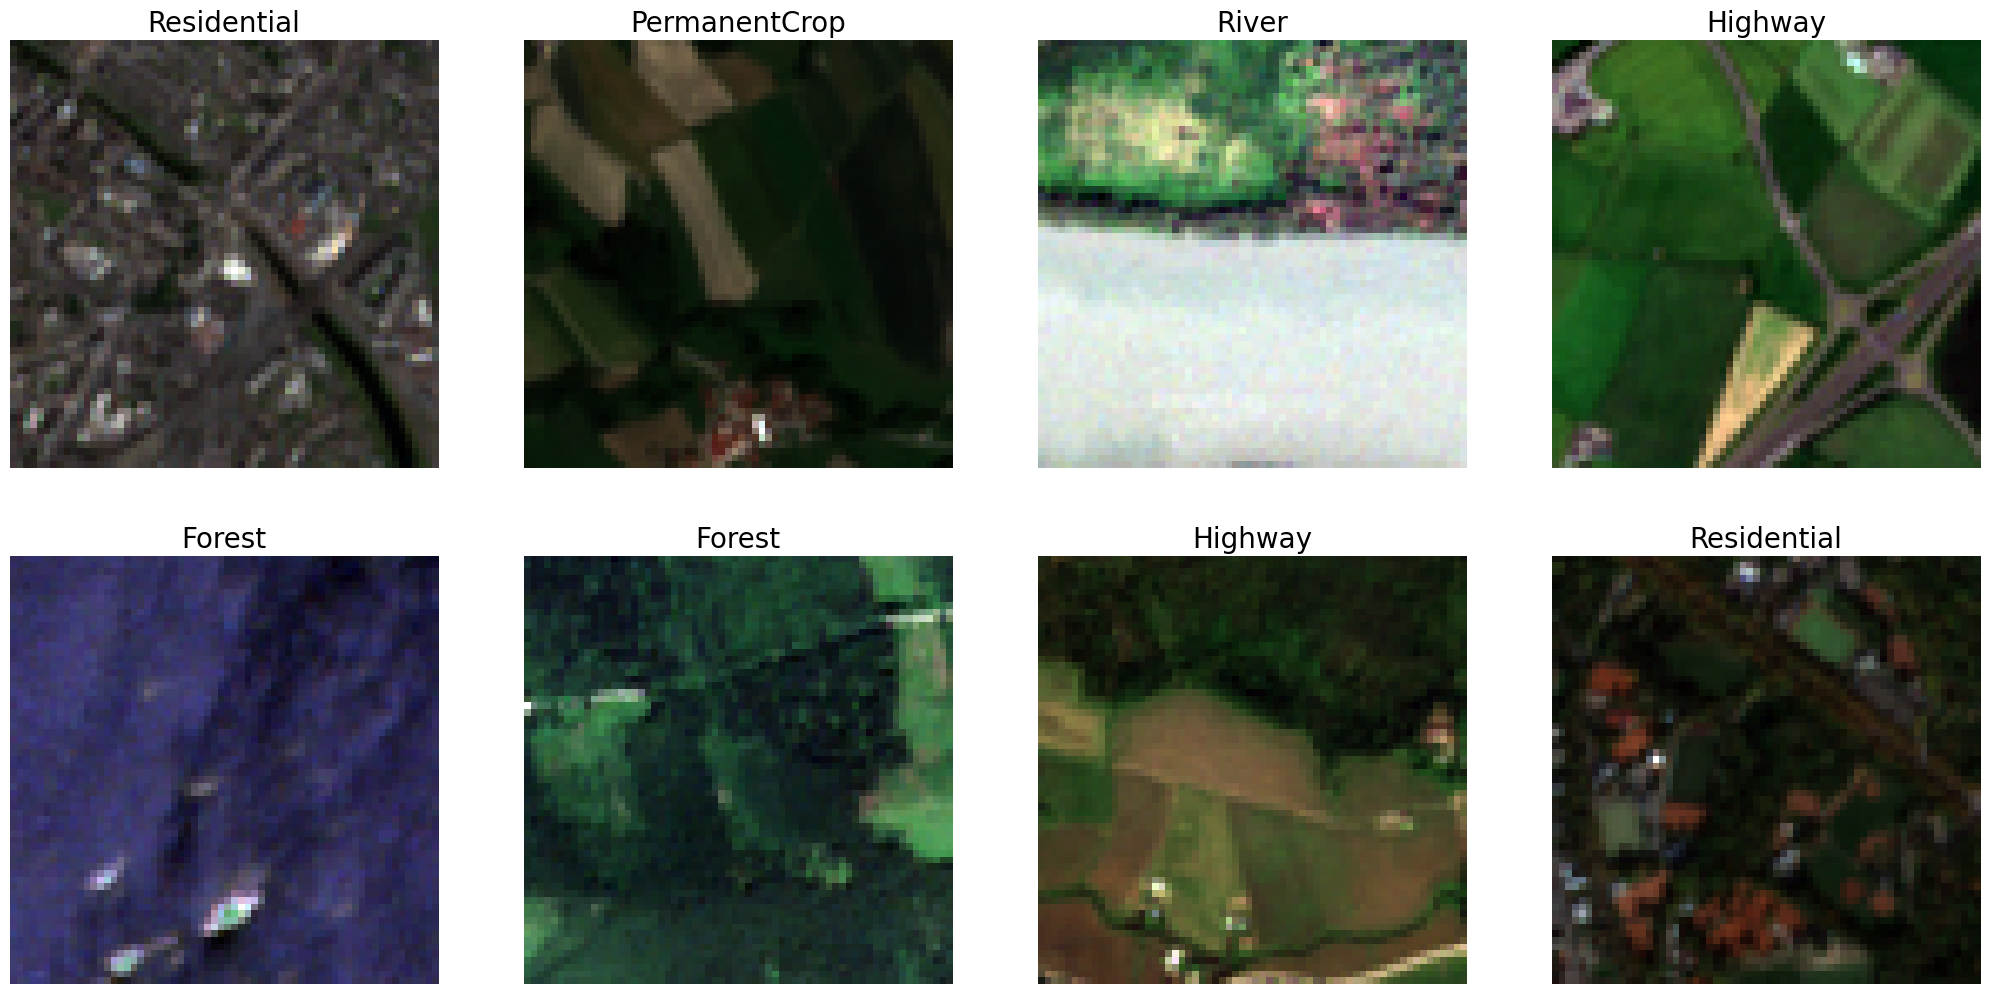

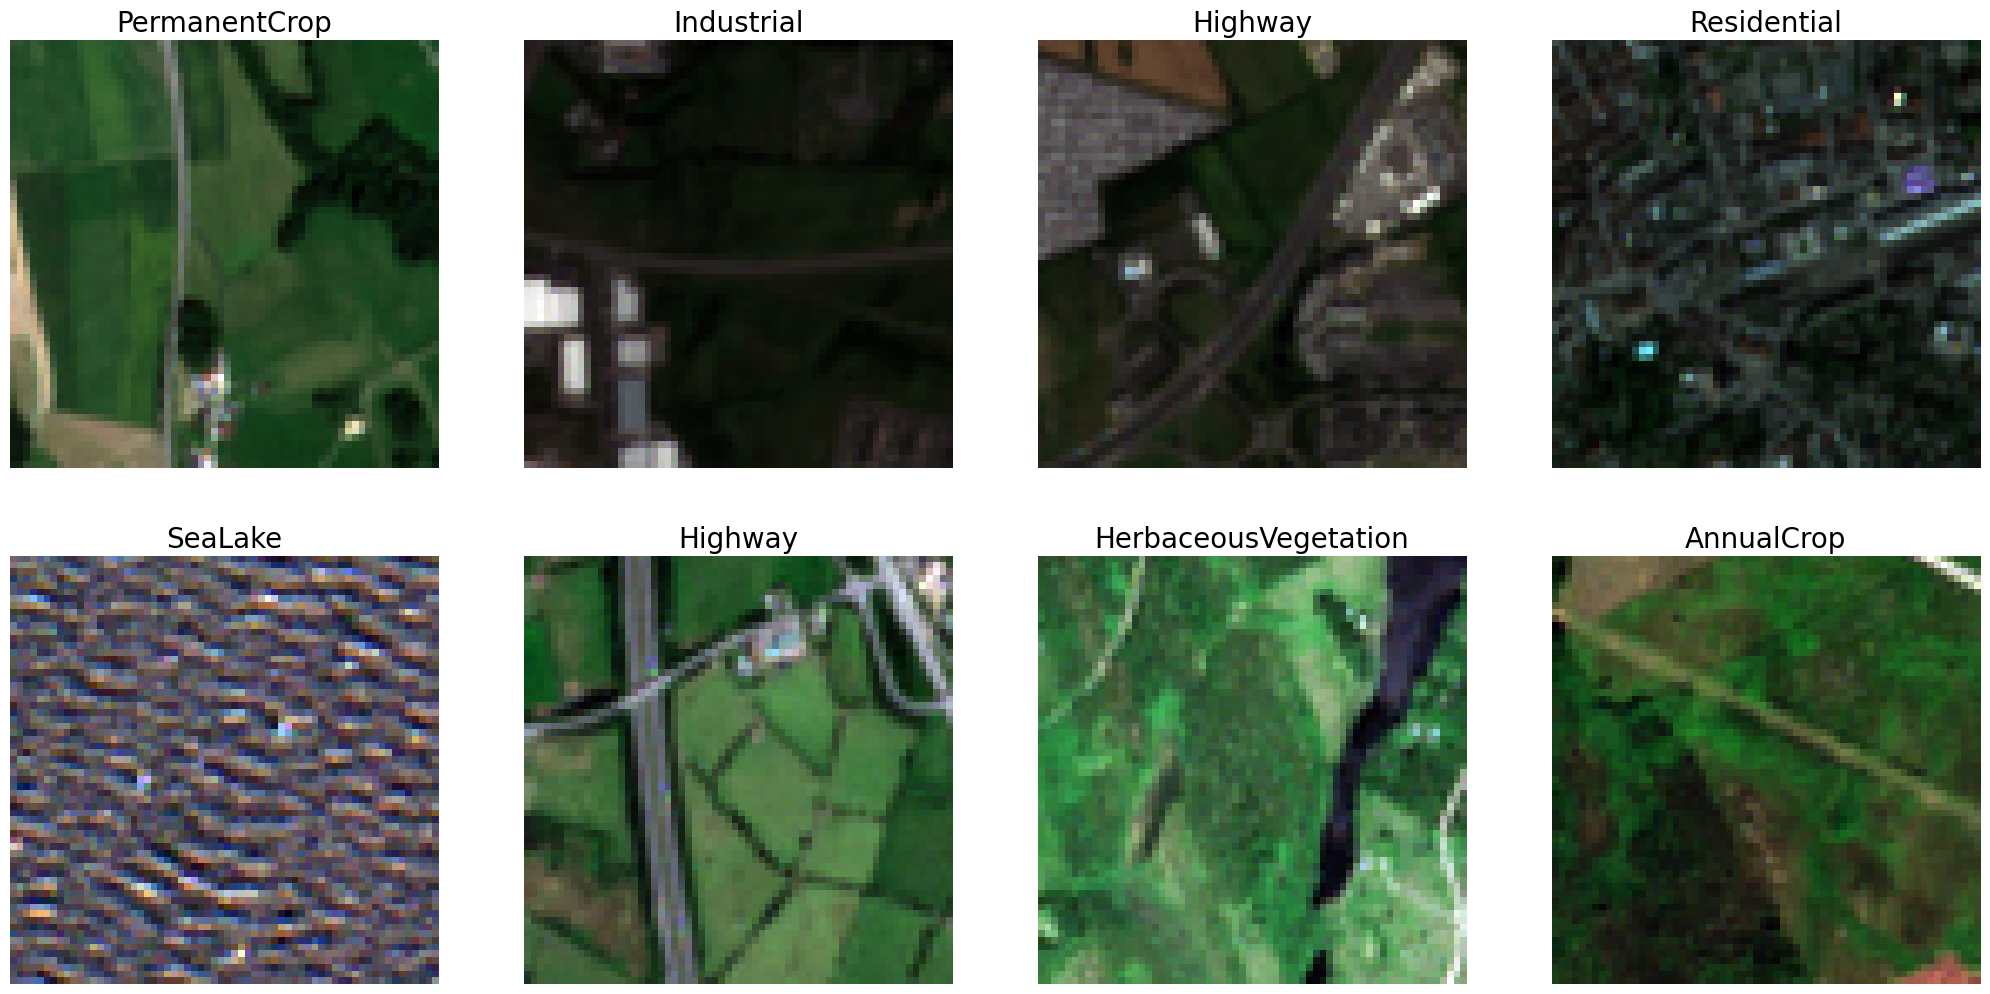

In [16]:
import random
from matplotlib import pyplot as plt

samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5


for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        
        im_path = f"data/test/NoLabel/test_{samp_id}.npy"
        img = images[idx].numpy().transpose(1, 2, 0)
        
        # img = np.load(im_path).transpose(2, 0, 1)
        # img = img[[3, 2, 1]].astype(np.float32)
        # 
        # 
        # # Normalize the image
        # rgb_min, rgb_max = img.min(), img.max()
        # img = (img - rgb_min) / (rgb_max - rgb_min)
        # 
        # img = img.transpose(1, 2, 0)

        # Plotting
        ax.imshow(img)
        ax.set_title(pred, fontsize=20)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()